__This analysis aims to determine whether the gamma radiation recorded by the satellite "Compton Gamma-Ray Observatory (CGRO)" has a constant emission rate.__

In [1]:
import numpy as np 
import pandas as pd 
import scipy 
import matplotlib.pyplot as plt

In [2]:
# Read data
data = pd.read_csv("Gamma radiation data.csv")

In [3]:
data.head()

,seconds,count
0,116.0,0.0
1,112.0,0.0
2,160.0,0.0
3,51.5,0.0
4,102.0,1.0


In [4]:
data.rename(columns={"seconds": "Seconds [t_i]", "count": "Count [S_i]"}, inplace=True)

In [5]:
data.head(2)

,Seconds [t_i],Count [S_i]
0,116.0,0.0
1,112.0,0.0


In [6]:
data.shape

(100, 2)

Since the count of gamma radiation events can only take integer values, discrete distributions are suitable for describing the data. In this case, the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) appears appropriate due to the nature of the problem.

__Poisson Distribution:__  <br>
<br>
 $P_{\lambda}(k) = \frac{\lambda^k}{k!} \cdot e^{-\lambda}$  <br>
 <br>
 with k=$N_0$ and ${\lambda}$>0

__Description:__<br>
$S_i$~Poisson(${\lambda}_i \cdot {t}_i$) = Count of gamma rays in the i-th time interval<br>
${\lambda}_i$ = Average count of gamma rays in the i-th time interval <br>
$t_i$ = Duration in seconds of the i-th time interval<br>
i = i-th time interval

The investigation essentially aims to determine whether $H_0:{\lambda}_0={\lambda}_1=...={\lambda}_{99}$ or 
$H_A:{\lambda}_i ≠ {\lambda}_j $ holds for any i and j.

Lambda is estimated using the __Maximum Likelihood Method__: <br>

$f(S_0,S_1,...,S_{99}|{\lambda})=\prod_{i=0}^{99} \frac{(\lambda\cdot t_i)^{S_i}}{S_i!} \cdot e^{-\lambda \cdot t_i}$ <br>

$\ln(f)=\ln(\prod_{i=0}^{99} \frac{(\lambda\cdot t_i)^{S_i}}{S_i!} \cdot e^{-\lambda \cdot t_i})$ 
$=-{\lambda}\sum_{i=0}^{99} t_i + \ln(\lambda)\sum_{i=0}^{99} S_i + \sum_{i=0}^{99}\ln(S_i) - \sum_{i=0}^{99}ln(S_i!)$ <br>

$\underset{\lambda}{\operatorname{argmax}} \ln(f): 0=ln(f) \frac{d}{d\lambda}= -\sum_{i=0}^{99} t_i+\sum_{i=0}^{99} \frac{S_i}{\lambda}$ <br>

$⇒\hat{\lambda}= \frac{\sum_{i=0}^{99}S_i}{\sum_{i=0}^{99}t_i}$ or $\hat{\lambda}_i= \frac{S_i}{t_i}$

In [7]:
# Calculation using the Maximum Likelihood Method
H0_lambda_hat = data['Count [S_i]'].sum() / data['Seconds [t_i]'].sum()
HA_lambda_hats = data['Count [S_i]'] / data['Seconds [t_i]']
print("H0 = {}".format(H0_lambda_hat))
print("HA = {}".format(HA_lambda_hats))

H0 = 0.0038808514969907496
HA = 0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.009804
        ...   
95    0.025840
96    0.000000
97    0.000000
98    0.000000
99    0.000000
Length: 100, dtype: float64


To test the test statistic, I use the __Likelihood Ratio Test__:<br>
${\Lambda}(x)=-2\ln(\frac{maxf(S_0,S_1,..,S99|\lambda)}{maxf(S_0,S_1,..,S99|\lambda_0,...,\lambda_{99})})$<br><br>
This follows a Chi-square distribution with ${\chi}^2_{99}$. The Type I error is set at ${\alpha}=5\%$.

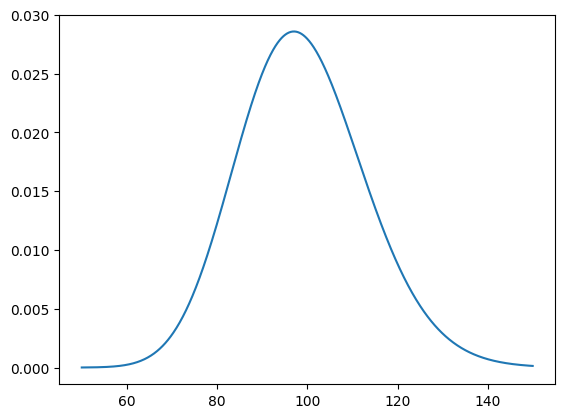

In [8]:
# Chi-square distribution for 99 degrees of freedom
X = np.arange(50,150,0.1)
plt.plot(X, scipy.stats.chi2.pdf(X, 99))
plt.show()

In [9]:
# The critical value of the test statistic for the Chi-square distribution with 99 degrees of freedom and Alpha 5%.
test_statistic = scipy.stats.chi2.isf(0.05, 99)
test_statistic

123.22522145336181

In [10]:
def H0_likelihood(lamb):
    # The likelihood function is the product of the Poisson distributions. For H0, each Poisson distribution has the same mean
    return scipy.stats.poisson.pmf(data['Count [S_i]'], data['Seconds [t_i]'] * lamb).prod(axis=0)

def HA_likelihood(lambs):
    # For HA, the means of the Poisson distribution are given by the lambdas
    return scipy.stats.poisson.pmf(data['Count [S_i]'], data['Seconds [t_i]'] * lambs).prod(axis=0)

In [11]:
# The observed test statistic value for the Chi-square distribution
test_statistic_observed = -2 * np.log(H0_likelihood(H0_lambda_hat) / HA_likelihood(HA_lambda_hats))
test_statistic_observed

104.39792133021314

In [12]:
# The p-value for the observed data
p_value = scipy.stats.chi2.sf(test_statistic_observed, 99)
p_value

0.33576662402509894

In [13]:
print(f"Test Statistic: {test_statistic:.2f}, Observed Test Statistic: {test_statistic_observed:.2f}")
print(f"Alpha: 0.05, p-Value: {p_value:.2f}")

Test Statistic: 123.23, Observed Test Statistic: 104.40
Alpha: 0.05, p-Value: 0.34


__Conclusion__: H0 cannot be rejected. The detected emission rate appears to be constant.

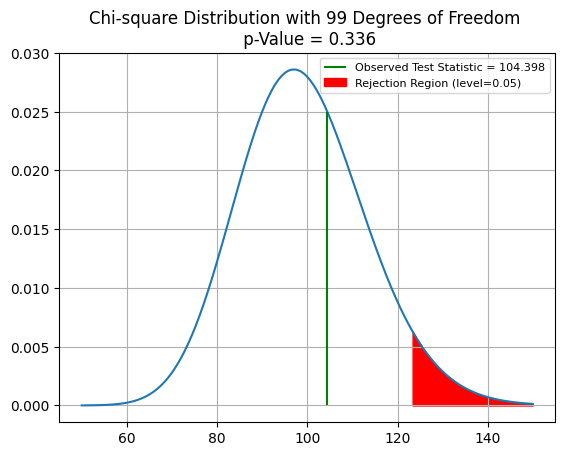

In [14]:
# Visualization of the Chi-square distribution and p-values
degrees_of_freedom = 99
significance_level = 0.05
plt.plot(X, scipy.stats.chi2.pdf(X, degrees_of_freedom))
plt.vlines(test_statistic_observed, 0, scipy.stats.chi2.pdf(test_statistic_observed, degrees_of_freedom), colors='g', label='Observed Test Statistic = {:.3f}'.format(test_statistic_observed))
plt.fill_between(X, scipy.stats.chi2.pdf(X, degrees_of_freedom), where=X>=test_statistic, color='red', label='Rejection Region (level={})'.format(significance_level))
plt.title(f'Chi-square Distribution with {degrees_of_freedom} Degrees of Freedom \n p-Value = {p_value:.3f}')

plt.legend(loc='upper right',  prop={'size': 8})
plt.grid()
plt.show()